In our case, the dataset will be a subset of an airline's customer database.  The data contains information from the customer file, combined with information from the records of flights that each customer has taken.  

Identifiers Contained in the Data

The original data set contains each customer's frequent flier account number, as well as name, date of birth, passport number (if known by the airline) and home address.  The fields for any direct identifiers will be not be extracted from the database, but the customer's calculated age, home zip code, and gender will be extracted from the database.

For each flight, the flight number, origin and destination codes, mileage, date and departure time will be included for each passenger in the subset.

The airline has also declared that the records of any minors be excluded from the data extraction to protect the most sensitive passengers.  

The stated objective of the release of data is for review of the data for improvements in the times and routes covered, but leaving open the possibility of additional findings by trying to show the data as deep as possible.

In [1]:
# import packages

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Lasso, Lars, SGDRegressor

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
#from crypt import AES
import random


#import locale
#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Data gathering 

In [3]:
#Use the flight data from our other project
OnTime = pd.read_csv("Data/20170112_DataMiningI_TestDataSet_EXP_DS.csv")
OnTime = OnTime.loc[OnTime['flight_type_code']!= 'X']
OnTime['route_sequence_number'] = OnTime['route_sequence_number']/100000000
#Create indicator for ontime performance, where 1 = OnTime and 0 = LATE
OnTime['OnTimeIndicator'] = np.where(OnTime['dot_delay_mins']>=15, 0, 1)
#Need some Time of Day buckets
OnTime['TimeBucket']=pd.cut(OnTime['local_scheduled_dep_time'],[0, 600, 700, 1200, 2000, 2200,2800],6, 
       labels=["deep_shoulder_am", "shoulder_am", "am_meat", "pm_meat", "shoulder_pm","deep_shoulder_pm"])
#Need an "International" code
OnTime['International'] = np.where(OnTime['origin_country']!=OnTime['destination_country'], 1, 0)
del OnTime['flt_attendant_change_ind']
OnTime['Originator_ind'] = np.where(OnTime['route_sequence_number']== 1.0,1,0)
OnTime['D_zero_ind'] = np.where(OnTime['push_delay_mins']== 0,1,0)


OnTime = OnTime.ix[:,['origin', 'destination', 'departure_date', 'flight_route_number']]

In [4]:
OnTime.columns

Index(['origin', 'destination', 'departure_date', 'flight_route_number'], dtype='object')

In [5]:
#Get a list of Zip Codes
ZipCode = pd.read_csv("free-zipcode-database-Primary.csv")
ZipCode.head()
ZipCode = ZipCode.sample(500)

In [6]:
#Build a dataset

ncustomer = 10000

#Customers 1->n
Customer = pd.DataFrame(list(range(0,ncustomer)), columns=["CustomerNumber"])

#Make half male
Gender = np.random.randint(0,2, size=(ncustomer,1))
Customer['Gender'] = Gender

#Create ages distributed normally from 18 to max of 90 with a mean of 37.8, maybe a 15 year standard deviation
Age = 4.8* np.random.randn(ncustomer,1) + 44
Customer['Age'] = Age


#print(Age)
#print(Age.min(), Age.max())
#sns.distplot(Age)


#Get a random sample of zipcodes

MyZip = np.array(ZipCode['Zipcode'].sample(ncustomer, replace = True))
MyZip.shape = (ncustomer,1)
Customer['ZipCode'] = MyZip

#randomly create a number of flights for a customer from 1-250 flights
TotalFlights=7 * np.random.randn(ncustomer, 1) + 4

#Convert to integer for flight numbers (round)
#Force negatives to 0
TotalFlights[TotalFlights<0] = 0
TotalFlights = TotalFlights.round().astype(int)
TotalFlights[TotalFlights>30] = 0
TotalFlights.shape = (ncustomer,1)
Customer['TotalFlights']=TotalFlights

Customer.head()
Customer.shape




(10000, 5)

In [7]:
CustFlight = []

#Loop through customers
for cust in Customer['CustomerNumber']:
    myflights = Customer['TotalFlights'][cust]

    if myflights > 0:
        #for each customer, select n random flights from the OnTime document
        thiscustomerflights = OnTime.sample(n=myflights)
        thiscustomerflights['customer'] = cust
        CustFlight.append(thiscustomerflights)
        #print(thiscustomerflights)


    
    #put into CustFlight

CustFlight = pd.concat(CustFlight, axis=0)
print(CustFlight)


       origin destination departure_date  flight_route_number  customer
45095     PHX         STL      5/30/2016                  281         0
25329     DAL         ABQ      5/19/2016                   42         0
99288     OAK         SAN       5/9/2016                   18         0
50845     SAN         BNA      5/28/2016                  585         0
104895    SJC         SAN      5/11/2016                  527         0
60222     MDW         FLL      5/26/2016                  416         0
75613     DTW         STL       5/1/2016                  368         0
6641      PHX         OAK      5/13/2016                  185         0
33689     BWI         CHS      5/13/2016                  347         0
104462    HOU         MSY      5/12/2016                  251         3
72089     FNT         MDW      5/26/2016                  243         3
48328     SEA         OAK      5/24/2016                  179         3
2356      SAN         TUS      5/21/2016                   50   

5.2320000000000002

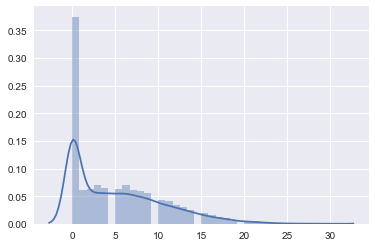

In [12]:
sns.distplot(TotalFlights)
TotalFlights.mean()

Quasi-Identifiers within this dataset include the intersection of Zip/Age/Gender.  Should we also include home airport as a quasi-idenitifer? This isn't necessarily a directly designated airport but it's the most frequent airport a flier goes to.

In [ ]:
#Does strong encryption of categorical variables allow for 
#a data digger to still backwards derive the flyer's identity?

In [16]:
# alex messing with code


In [38]:
# read in names

male_first_names = pd.read_csv('Data/census-dist-male-first.csv')

female_first_names = pd.read_csv('Data/census-dist-female-first.csv')

last_names = pd.read_csv('Data/dist.all.last.csv')

print(male_first_names.head(), female_first_names.head(), last_names.head())




      name  value  value_2  number
0    JAMES  3.318    3.318       1
1     JOHN  3.271    6.589       2
2   ROBERT  3.143    9.732       3
3  MICHAEL  2.629   12.361       4
4  WILLIAM  2.451   14.812       5         name  value  value_2  number
0       MARY  2.629    2.629       1
1   PATRICIA  1.073    3.702       2
2      LINDA  1.035    4.736       3
3    BARBARA  0.980    5.716       4
4  ELIZABETH  0.937    6.653       5        name  value  value_2  number
0     SMITH  1.006    1.006       1
1   JOHNSON  0.810    1.816       2
2  WILLIAMS  0.699    2.515       3
3     JONES  0.621    3.136       4
4     BROWN  0.621    3.757       5


In [89]:
# create names -THIS DOESNT WORK...NOT SURE WHY

for person in Customer['CustomerNumber']:
    if (Customer['Gender']==1).bool == True:
        Customer['first_name'] = male_first_names['name'].sample(n= 1)
    else:
        Customer['first_name'] = female_first_names['name'].sample(n=1)
        



In [95]:
for person in Customer['CustomerNumber']:
        Customer['first_name'] = male_first_names['name'].sample(n= 1)
   

In [ ]:
#With or Without encryption can we demonstrate l-diversity, k-anononymous, and t-closeness of the slices?
#Or demonstrate what the odds of reidentification are for a flyer?

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: first_name, dtype: object

In [ ]:
#How can we avoid reidentification of a flyer based on background knowledge?